# Imports

In [3]:
import os
import io
import glob
import shutil
from shutil import copyfile, move

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
import soundfile as sf
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, Adamax

import tensorflow 
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Classes

In [4]:
class AudioFeatureExtractor:
    def __init__(self, df, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length
        self.df = df

    def features_extraction(self, preprocess=True, trim=True, pad=True, extended=False):
        zcr_list = []
        mfccs_list = []
        emotion_list = []

        if extended:
            rms_list = []
            spectral_centroid_list = []
            spectral_rolloff_list = []
            melspectrogram_list = []
            chroma_stft_list = []
        
        for row in self.df.itertuples(index=False):
            audio, sr = librosa.load(row.audio_path)

            if preprocess:
                audio = self.preprocess_audio(audio, trim, pad)
    
            zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=self.frame_length, hop_length=self.hop_length)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30, hop_length=self.hop_length)

            zcr_list.append(zcr)
            mfccs_list.append(mfccs)
            emotion_list.append(row.emotions)

            if extended:
                spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=self.hop_length)
                spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=self.hop_length)
                melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=self.hop_length)
                chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=self.hop_length)
                rms = librosa.feature.rms(y=audio, frame_length=self.frame_length, hop_length=self.hop_length)
                
                rms_list.append(rms)
                spectral_centroid_list.append(spectral_centroid)
                spectral_rolloff_list.append(spectral_rolloff)
                melspectrogram_list.append(melspectrogram)
                chroma_stft_list.append(chroma_stft)

        if extended:
            return zcr_list, mfccs_list, rms_list, spectral_centroid_list, spectral_rolloff_list, melspectrogram_list, chroma_stft_list, emotion_list
    
        return zcr_list, mfccs_list, emotion_list

    def create_arrays_data(self, preprocess=True):
        zcr_list, mfccs_list, emotion_list = self.features_extraction()

        X = np.concatenate((
            np.swapaxes(zcr_list, 1, 2), 
            np.swapaxes(mfccs_list, 1, 2)), 
            axis=2
        )
        X = X.astype('float32')
        y = np.asarray(emotion_list)
        df = pd.DataFrame({'emotions':emotion_list, 'zcr':zcr_list, 'mfccs': mfccs_list})
            
        return X, y, df

    def create_means_data(self, preprocess=True):
        data = self.features_extraction(pad=False, extended=True)
        zcr_means = [np.mean(array) for array in data[0]]
        mfcc_means = [np.mean(array) for array in data[1]]
        rms_means = [np.mean(array) for array in data[2]]
        spectral_centroid_means = [np.mean(array) for array in data[3]]
        spectral_rolloff_means = [np.mean(array) for array in data[4]]
        melspectrogram_means = [np.mean(array) for array in data[5]]
        chroma_stft_means = [np.mean(array) for array in data[6]]

        emotions_list = data[7]
        
        X = np.array([zcr_means, mfcc_means, rms_means, spectral_centroid_means, spectral_rolloff_means, melspectrogram_means, chroma_stft_means])
        X = np.swapaxes(X, 0, 1)
        X = X.astype('float32')
        X = X.reshape(X.shape[0], X.shape[1], 1)

        y = np.asarray(emotions_list)

        df = pd.DataFrame({'emotions':emotions_list, 'zcr_mean':zcr_means, 'mfccs_mean': mfcc_means, 'rms_mean':rms_means, 'spectral_centroid_mean':spectral_centroid_means,
                           'spectral_rolloff_mean':spectral_rolloff_means, 'melspectrogram_mean':melspectrogram_means, 'chroma_stft_mean':chroma_stft_means})

        return X, y, df
    
    def preprocess_audio(self, audio, trim =True, pad = True, samples_count=160000, silence_db=25):
        if trim:
            audio = self.trim_audio(audio, silence_db)
        if pad:
            audio = self.pad_audio(audio, samples_count)
        return audio

    def trim_audio(self, audio, silence_db):
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
        return trimmed_audio

    def pad_audio(self, audio, samples_count):
        padded_audio = np.pad(audio, (0, samples_count-len(audio)), 'constant')
        return padded_audio

In [5]:
class SpectrogramDataCreator:
    def __init__(self, num_mels=224, width=96, height=64):
        self.num_mels = num_mels
        self.max_length = 0
        self.width = width
        self.height = height

    def create_data(self, df, save_folder):
        X_spectrogram = []
        y = []
        
        os.makedirs(save_folder, exist_ok=True)

        for i, row in df.iterrows():
            audio_path = row['audio_path']
            emotion = row['emotions']
            dataset = row['dataset']
            spectrogram = self._extract_spectrogram(audio_path)
            X_spectrogram.append(spectrogram)
            y.append(emotion)

            # Save the spectrogram as an image
            filename = f"{dataset}_index{i}_{emotion}.png"
            filepath = os.path.join(save_folder, filename)
            self._save_spectrogram_image(spectrogram, filepath)

            # Update maximum length if needed
            if spectrogram.shape[1] > self.max_length:
                self.max_length = spectrogram.shape[1]

        # Apply padding or truncation with the computed maximum length
        for i in range(len(X_spectrogram)):
            if X_spectrogram[i].shape[1] < self.max_length:
                pad_width = self.max_length - X_spectrogram[i].shape[1]
                X_spectrogram[i] = np.pad(X_spectrogram[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                X_spectrogram[i] = X_spectrogram[i][:, :self.max_length]

        X_spectrogram = np.array(X_spectrogram)
        y = np.array(y)

        return X_spectrogram, y, self.max_length

    def _extract_spectrogram(self, audio_path):
        audio, sr = librosa.load(audio_path)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=self.num_mels)
        return spectrogram

    def _save_spectrogram_image(self, spectrogram, filepath):
        plt.figure(figsize=(self.width / 100, self.height / 100), dpi=100)  # Set the figure size to 96x64
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', x_axis='time')
        plt.axis('off')  # Remove axis ticks and labels
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove unnecessary margins
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)  # Save the image without extra padding
        plt.close()

In [6]:
class MFCCDataCreator:
    def __init__(self, num_mfcc=30):
        self.num_mfcc = num_mfcc
        self.max_length = 0

    def create_data(self, df):
        X_mfcc = []
        X_audio = []
        sr_list = []
        y = []

        for i, row in df.iterrows():
            audio_path = row['audio_path']
            emotion = row['emotions']
            mfcc, audio, sr = self._extract_mfcc(audio_path)
            X_mfcc.append(mfcc)
            X_audio.append(audio)
            sr_list.append(sr)

            y.append(emotion)
            # Update maximum length if needed
            if mfcc.shape[1] > self.max_length:
                self.max_length = mfcc.shape[1]

        # Apply padding or truncation with the computed maximum length
        for i in range(len(X_mfcc)):
            if X_mfcc[i].shape[1] < self.max_length:
                pad_width = self.max_length - X_mfcc[i].shape[1]
                X_mfcc[i] = np.pad(X_mfcc[i], pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                X_mfcc[i] = X_mfcc[i][:, :self.max_length]

        X_mfcc = np.array(X_mfcc)
        X_audio = np.array(X_audio)
        sr_list = np.array(sr_list)
        y = np.array(y)

        return X_mfcc, X_audio, sr_list, y, self.max_length
    
    # extract_mfcc function is an internal method
    def _extract_mfcc(self, audio_path):
        audio, sr = librosa.load(audio_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.num_mfcc)
        return mfcc, audio, sr

In [7]:
class DataPreprocessor:
    def __init__(self, X, y, dataframe):
        self.X = X
        self.y = y
        self.dataframe = dataframe
        self.num_classes = len(dataframe['emotions'].unique())
        self.class_labels = list(dataframe['emotions'].unique())
        self.label_encoder = LabelEncoder()
    
    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        # This methods splits the arrays after the mfcc extraction
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            self.X, self.y, test_size=test_size, shuffle=True, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, random_state=random_state)
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def split_dataframe(self, test_size=0.2, val_size=0.1, random_state=42):
        # Splitting the data into train, val, test datasets
        train_val, test = train_test_split(self.dataframe, test_size=test_size, shuffle=True, random_state=random_state)
        train, val = train_test_split(train_val, test_size=val_size, shuffle=True, random_state=random_state)

        train = train.reset_index(drop=True)
        val = val.reset_index(drop=True)
        test = test.reset_index(drop=True)
        return train, val, test
    
    def normalize_data(self, X_train, X):
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_scaled = (X - mean) / std
        return X_scaled
    
    def modify_channels(self, X):
        X_modified = X[..., np.newaxis]
        return X_modified
    
    def encode_labels(self, y_train, y_val, y_test):
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)
        return y_train_encoded, y_val_encoded, y_test_encoded
    
    def one_hot_encode_labels(self, y_encoded):
        y_categorical = to_categorical(y_encoded, self.num_classes, dtype='float32')
        return y_categorical
    
    def preprocess_data(self):
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data()
        X_train_scaled = self.normalize_data(X_train, X_train)
        X_val_scaled = self.normalize_data(X_train, X_val)
        X_test_scaled = self.normalize_data(X_train, X_test)
        X_train_modified = self.modify_channels(X_train_scaled)
        X_val_modified = self.modify_channels(X_val_scaled)
        X_test_modified = self.modify_channels(X_test_scaled)
        y_train_encoded, y_val_encoded, y_test_encoded = self.encode_labels(y_train, y_val, y_test)
        y_train_categorical = self.one_hot_encode_labels(y_train_encoded)
        y_val_categorical = self.one_hot_encode_labels(y_val_encoded)
        y_test_categorical = self.one_hot_encode_labels(y_test_encoded)
        
        return X_train_modified, X_val_modified, X_test_modified, y_train_categorical, y_val_categorical, y_test_categorical, self.num_classes, self.class_labels

In [8]:
class DataAugmentation:
    def __init__(self) -> None:
        pass

    def shift_pitch(self, audio, sr, semitones):
        shifted_audio = librosa.effects.pitch_shift(audio, n_steps=float(semitones), sr=sr)
        return shifted_audio
    
    def time_shift(self, audio, sr, shift_range=5):
        shift_samples = np.random.randint(-shift_range, shift_range)*1000
        shifted_audio = np.roll(audio, shift=shift_samples)
        return shifted_audio
    
    def time_stretch(self, audio, rate):
        stretched_audio = librosa.effects.time_stretch(audio, rate=rate)
        return stretched_audio
    
    def add_noise(self, audio, noise_factor):
        noise = np.random.randn(len(audio))
        noise_factor = noise_factor *np.random.uniform() * np.amax(audio)
        noisy_audio = audio + noise_factor * noise
        return noisy_audio

In [9]:
class EmotionClassifier:
    def _init_(self, model, num_classes, class_labels, dataframe):
        self.model = model
        self.dataframe = dataframe
        self.num_classes = num_classes
        self.class_labels = class_labels
    
    def predict_sample(self, test):

        # Randomly choose a sample from X_test_scaled
        sample_index  = np.random.choice(self.dataframe.shape[0])
        # Get the selected sample
        sample = test[sample_index]

        prediction = self.model.predict(np.expand_dims(sample, axis=0))
        predicted_class = np.argmax(prediction)
        predicted_emotion = self.class_labels[predicted_class]
        
        # Display sample and prediction
        print("Sample Emotion:", self.dataframe.iloc[sample_index].emotions)
        print("Predicted Emotion:", predicted_emotion)
        
        # Display sound 
        audio = ipd.Audio(self.dataframe.iloc[sample_index].audio_path)
        display(audio)
        
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)
        
    def plot_confusion_matrix(self, X_test, y_test, class_labels):
        y_pred = self.model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        # Convert y_pred from label-encoded to one-hot encoded format
        y_pred_onehot = to_categorical(y_pred, self.num_classes)

        # Decode y_pred and y_test back to their original class labels
        label_encoder = LabelEncoder()
        label_encoder.fit(class_labels)
        y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_onehot, axis=1))
        y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
 
        cm = confusion_matrix(y_test_labels, y_pred_labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Emotion")
        plt.ylabel("True Emotion")
        plt.title("Confusion Matrix")
        plt.show()

        # Calculate row sums for percentage calculation
        row_sums = cm.sum(axis=1, keepdims=True)

        # Calculate confusion matrix in percentage format
        cm_percentage = (cm / row_sums) * 100

        # Plot the confusion matrix in percentage format
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix (Percentage)")
        plt.show()

    def plot_metrics(self, history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Functions

In [10]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history['val_' + metric]
    
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.title('Model ' + metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [11]:
def create_early_stopping_callback(patience=5):
    return EarlyStopping(patience=patience, monitor="val_loss", mode='min', verbose=1)

def create_model_checkpoint_callback(file_name, monitor="val_accuracy"):
    return ModelCheckpoint(file_name, save_best_only=True, monitor=monitor)

def create_reduce_lr_callback(monitor="val_accuracy", patience=5):
    return ReduceLROnPlateau(factor=0.1, patience=patience, monitor=monitor, min_lr=0.000001)

# Data Collection

In [2]:
RAVDESS = "./data/ravdess-emotional-speech-audio/"
CREMA = "./data/cremad/"
TESS = "./data/toronto-emotional-speech-set-tess/"
SAVEE = "./data/surrey-audiovisual-expressed-emotion-savee/"

## Ravdess dataframe

In [3]:
ravdess_actors_list = os.listdir(RAVDESS)
audio_emotion = []
audio_path = []
audio_gender = []
audio_intensity = []
durations = []

for file in ravdess_actors_list:
    actor = os.listdir(os.path.join(RAVDESS,file))
    for audio in actor:
        list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
        list_audio = list_audio.split('-') # splitting by the dash
        gender_code = int(list_audio[6])
        
        audio_emotion.append(int(list_audio[2])) # the third element describes the emotion class
        audio_gender.append('female' if gender_code & 1 == 0 else 'male') # the sixth element describes the voice gender 
        audio_intensity.append('normal' if int(list_audio[3]) == 1 else 'high')
        audio_path.append(os.path.join(RAVDESS,file,audio))
        
        audio, sr = librosa.load(os.path.join(RAVDESS,file,audio))
        durations.append(librosa.get_duration(y=audio, sr=sr))

ravdess_df = pd.DataFrame({'emotions': audio_emotion, 'genders': audio_gender, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})

# Mapping the values to emotions
emotion_dict = {
    1: 'neutral',
    2: 'neutral', # originally - - > 'calm'
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprised',
}

# Replace the values in the column with emotions
ravdess_df['emotions'] = ravdess_df['emotions'] .replace(emotion_dict)
ravdess_df['dataset'] = 'ravdess'
ravdess_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess


## Crema dataframe

In [4]:
crema_list = os.listdir(CREMA)
audio_emotion = []
audio_path = []
audio_intensity = []
gender_list = []
durations = []

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

emotion_dict = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

intensity_dict = {
    'XX' : 'normal',
    'X' : 'normal',
    'LO' : 'low',
    'MD' : 'normal',
    'HI': 'high'
}

for audio in crema_list:
    list_audio = audio.split('.')[0] # splitting by the '.' into '**-**-**' . 'wav' and grab the first element
    list_audio = list_audio.split('_') # splitting by the underline
    audio_emotion.append(list_audio[2])
    audio_intensity.append(list_audio[3])
    audio_path.append(os.path.join(CREMA,audio))
    gender_list.append('female' if list_audio[0] in female_id_list else 'male')
    
    audio, sr = librosa.load(os.path.join(CREMA,audio))
    durations.append(librosa.get_duration(y=audio, sr=sr))
    
crema_df = pd.DataFrame({'emotions': audio_emotion, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': audio_path, 'duration':durations})
crema_df['emotions'] = crema_df['emotions'].replace(emotion_dict)
crema_df['audio_intensity'] = crema_df['audio_intensity'].replace(intensity_dict)
crema_df['dataset'] = 'crema'
crema_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,male,normal,./data/cremad/1001_DFA_ANG_XX.wav,2.275601,crema
1,disgust,male,normal,./data/cremad/1001_DFA_DIS_XX.wav,2.335692,crema
2,fear,male,normal,./data/cremad/1001_DFA_FEA_XX.wav,2.168844,crema
3,happy,male,normal,./data/cremad/1001_DFA_HAP_XX.wav,1.868526,crema
4,neutral,male,normal,./data/cremad/1001_DFA_NEU_XX.wav,2.035420,crema


## TESS dataframe

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 
audio_intensity = []
durations = []

emotion_dict = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'ps'     : 'surprised',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        path_list.append(os.path.join(TESS,directory,audio_file))
        gender_list.append('female') # female only dataset
        audio_intensity.append('normal') # normal only dataset
        emotion_list.append(part.split('_')[2])
        
        audio, sr = librosa.load(os.path.join(TESS,directory,audio_file))
        durations.append(librosa.get_duration(y=audio, sr=sr))
            
tess_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list, 'duration':durations})
tess_df['emotions'] = tess_df['emotions'].replace(emotion_dict)
tess_df['dataset'] = 'tess'
tess_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.539048,tess
1,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.616644,tess
2,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.542041,tess
3,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.606893,tess
4,angry,female,normal,./data/toronto-emotional-speech-set-tess/OAF_a...,1.395193,tess


## SAVEE dataframe

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []
audio_intensity = []
durations = []

emotion_dict = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust',
    'su' : 'surprised'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    path_list.append(os.path.join(SAVEE,audio_file))
    gender_list.append('male') # male only dataset
    emotion_list.append(part[:-6])
    audio_intensity.append('normal') # normal only dataset
    
    audio, sr = librosa.load(os.path.join(SAVEE,audio_file))
    durations.append(librosa.get_duration(y=audio, sr=sr))
        
savee_df = pd.DataFrame({'emotions': emotion_list, 'genders': gender_list, 'audio_intensity': audio_intensity, 'audio_path': path_list,'duration':durations})
savee_df['emotions'] = savee_df['emotions'].replace(emotion_dict)
savee_df['dataset'] = 'savee'

savee_df.head()

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.647800,savee
1,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.438141,savee
2,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.075510,savee
3,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.725351,savee
4,angry,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.997914,savee


In [7]:
merged_df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0)
merged_df.reset_index(inplace=True, drop=True)
merged_df.to_csv('merged_df.csv',index=False)
merged_df

,emotions,genders,audio_intensity,audio_path,duration,dataset
0,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.303311,ravdess
1,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.336689,ravdess
2,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.269932,ravdess
3,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.169841,ravdess
4,neutral,male,normal,./data/ravdess-emotional-speech-audio/Actor_01...,3.536871,ravdess
...,...,...,...,...,...,...
12157,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,2.014059,savee
12158,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.904263,savee
12159,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,3.532381,savee
12160,surprised,male,normal,./data/surrey-audiovisual-expressed-emotion-sa...,5.267619,savee


# EDA

## Exploring the data

Text(0.5, 1.0, 'Distribution of Emotions')

<Figure size 1000x600 with 0 Axes>

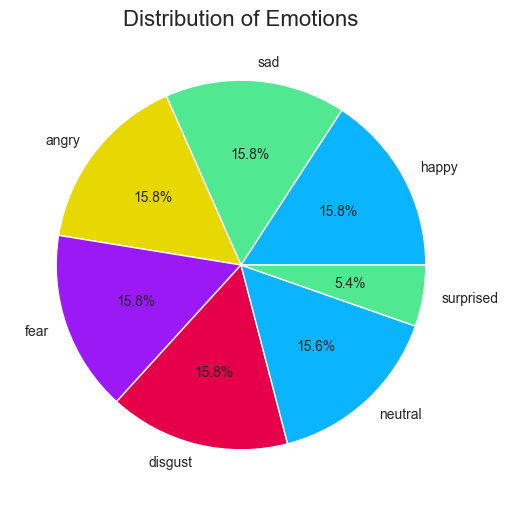

In [8]:
plt.figure(figsize=(10,6))
emotion_percent = merged_df['emotions'].value_counts(normalize=True) * 100

# Set a threshold for small percentage slices
threshold = 5

# Identify emotions below the threshold
small_emotions = emotion_percent[emotion_percent < threshold]

# Create a list of explode values
explode = [0.1 if emotion in small_emotions else 0 for emotion in emotion_percent.index]

# Set the figure size
plt.figure(figsize=(10, 6))

# Define a custom color palette
color_palette = ["#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#e60049"] 

# Create the pie chart with explode values
plt.pie(emotion_percent, labels=emotion_percent.index, autopct='%1.1f%%', colors=color_palette, explode=explode)

# Set the title
plt.title('Distribution of Emotions', size=16)

The pie chart represents the distribution of emotion types in the dataset. <br>
It is evident that apart from the surprised tone with 5.4% , the other types of tones are around 14-16%. <br>
Worth mentioning that the tone 'calm' with its 1.6% distribution in the dataset, was merged with the neutral tone.

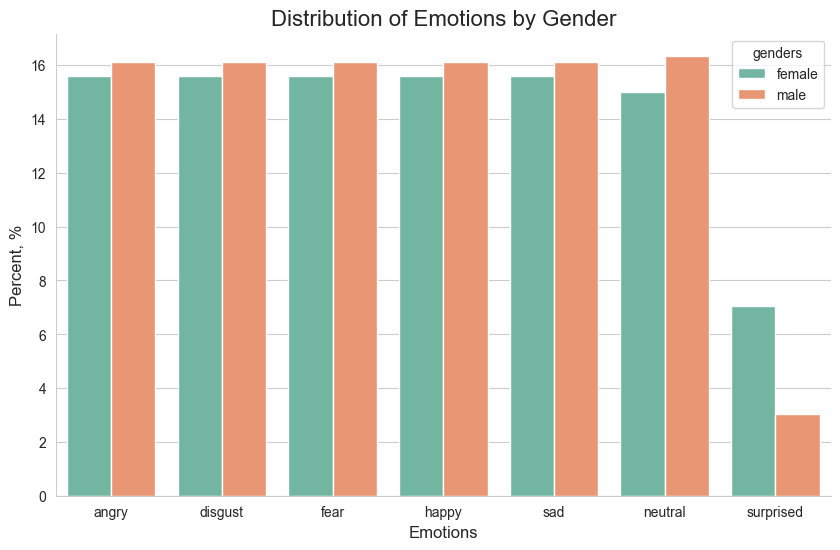

In [9]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('genders')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='genders', palette='Set2')

plt.title('Distribution of Emotions by Gender', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The distribution of emotions in the entire dataset by the gender is relatively uniform.

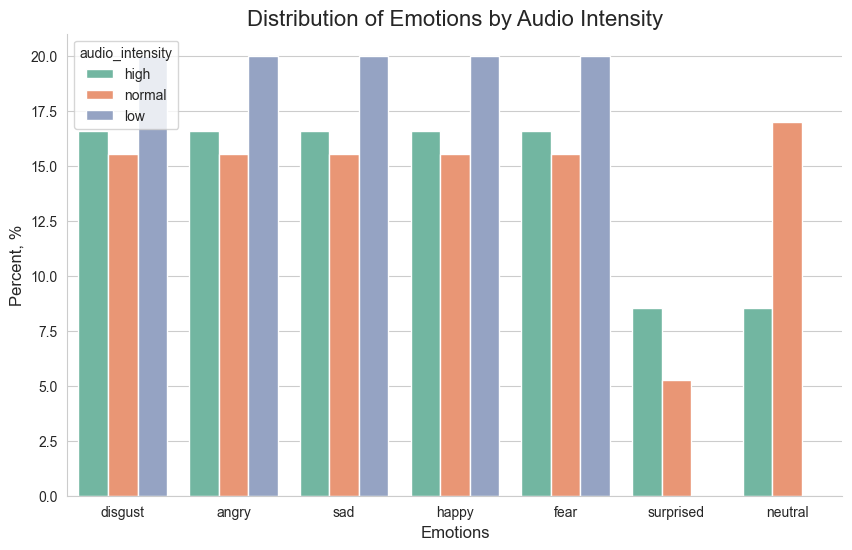

In [10]:
# Calculate the percentage of each emotion by gender
emotions_by_gender = merged_df.groupby('audio_intensity')['emotions'].value_counts(normalize=True) * 100

# Reset the index to convert the result into a DataFrame
emotions_by_gender = emotions_by_gender.reset_index(name='percentage')

plt.figure(figsize=(10,6))

sns.barplot(emotions_by_gender, x='emotions', y='percentage', hue='audio_intensity', hue_order=['high', 'normal', 'low'], palette='Set2')

plt.title('Distribution of Emotions by Audio Intensity', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Percent, %', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine() # Remove the top and right spines

The audio intensity distribution is divided by high, normal, and low. Neutral and surprised tones have only two intensities, normal and high. <br>
The total distribution is uniform between all the modes of the tone intensity (15%-20%), where only in neutral tone there is a higher percentage of normal intensity. 

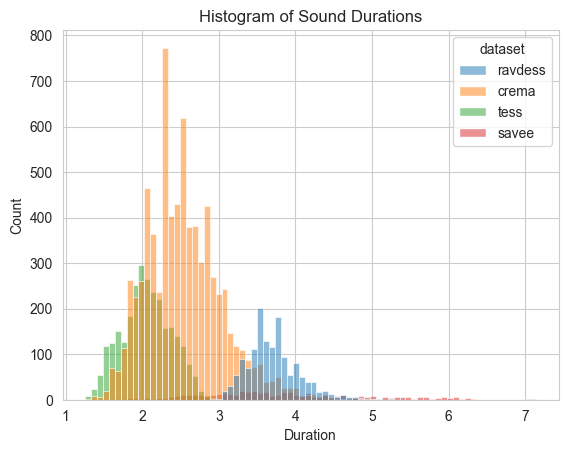

In [11]:
# Create a histogram using seaborn
sns.histplot(data=merged_df, x='duration', hue='dataset')

# Set labels and title
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Histogram of Sound Durations')

# Display the histogram
plt.show()

In [12]:
print(f"max input audion duration is {round(merged_df['duration'].max(),2)}")

max input audion duration is 7.14


The audio duration distribution of each dataset is slightly different, with the SAVEE dataset having the biggest spread.
This means that as part of the data preparation for the model, we'll need to pad the audio files with zeroes based on the longest audio files in the dataset.

## Demonstration of various audio files

In [13]:
def play_random_audio(dataframe, gender, emotion, intensity, preprocess=False):
    # Filter the DataFrame based on the given criteria
    filtered_df = dataframe[(dataframe['genders'] == gender) & (dataframe['emotions'] == emotion) & (dataframe['audio_intensity'] == intensity)]
    
    # Randomly select an audio file path
    file_path = random.choice(np.array(filtered_df['audio_path']))
    
    # Load the audio file using librosa
    audio, sr = librosa.load(file_path)

    # Applying preprocess
    if preprocess:
        audio = preprocess_audio(audio)
        
    # Display the waveform plot
    plt.figure(figsize=(12, 4))

    # Waveform plot
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f'Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram plot
    plt.subplot(1, 2, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    img = librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel frequency')
    plt.colorbar(format='%+2.0f dB')  # A colorbar with dB format

    plt.subplots_adjust(wspace=0.4)  #  Horizontal spacing between subplots
    plt.suptitle(f'Dataset: {dataframe[dataframe["audio_path"]==file_path]["dataset"].values[0]}, Gender: {gender}, Emotion: {emotion}, Intensity: {intensity}', weight='bold', size=16)
    plt.tight_layout()

    # Play the audio
    return ipd.Audio(file_path)

Examples of random audio samples

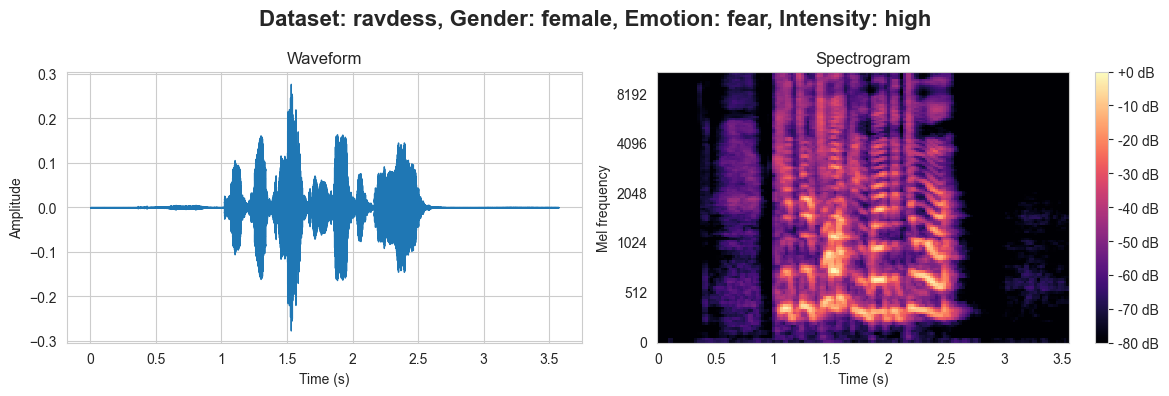

In [14]:
play_random_audio(merged_df, gender="female", emotion="fear", intensity="high")

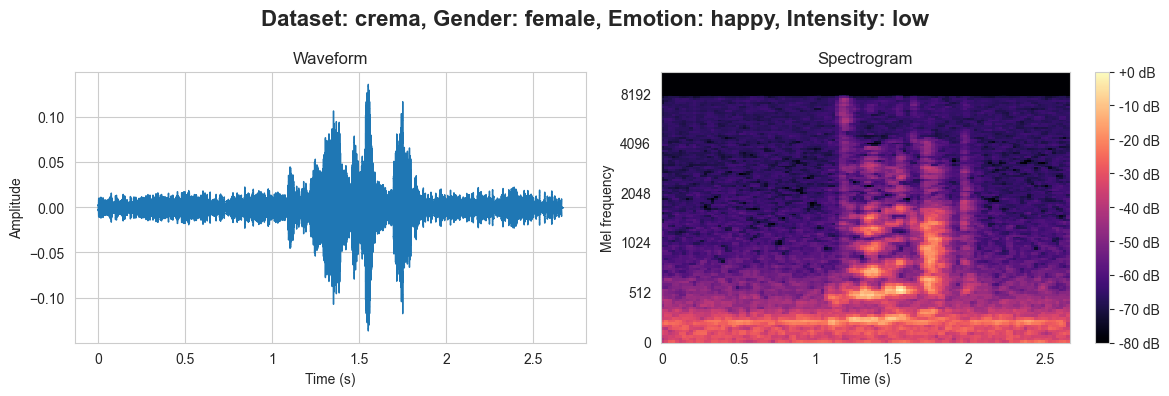

In [15]:
play_random_audio(merged_df, gender="female", emotion="happy", intensity="low")

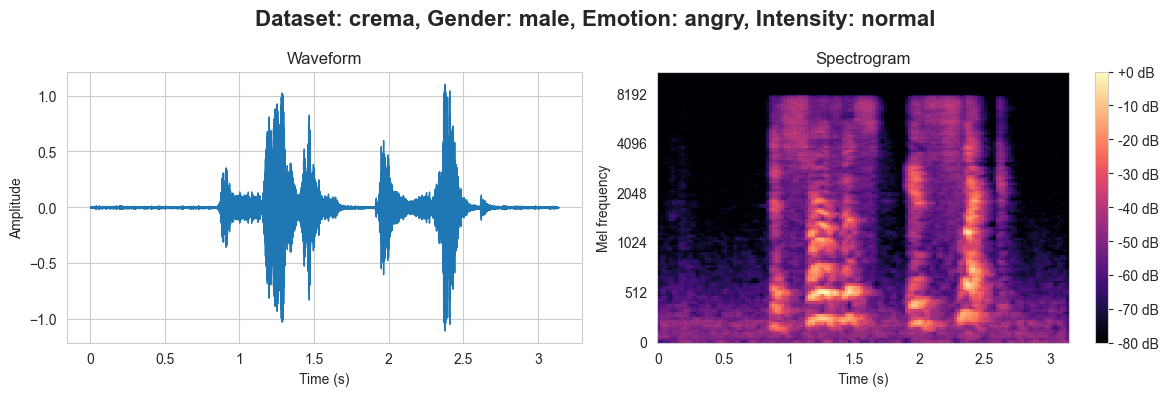

In [16]:
play_random_audio(merged_df, gender="male", emotion="angry", intensity="normal")

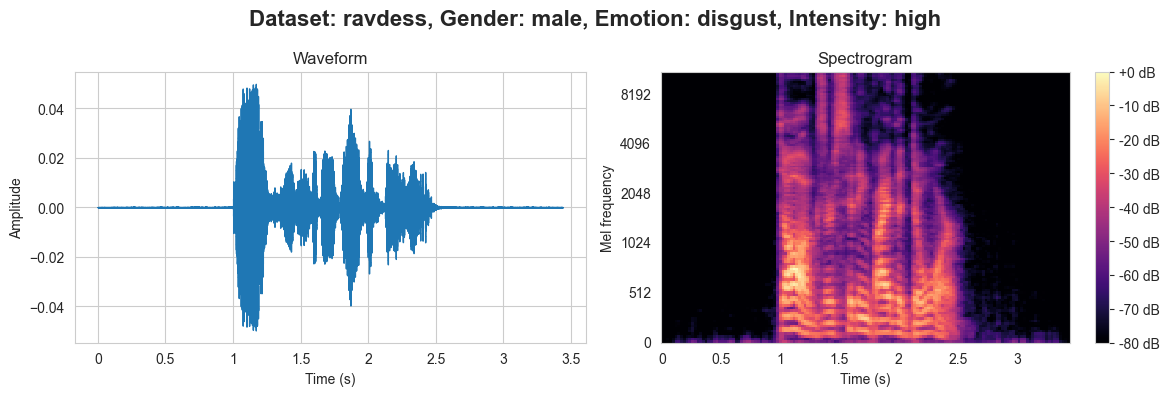

In [17]:
play_random_audio(merged_df, gender="male", emotion="disgust", intensity="high")

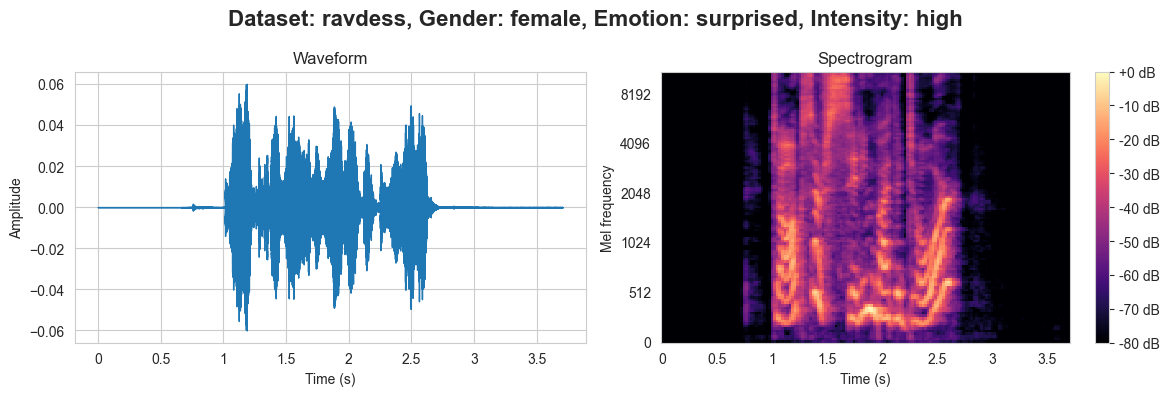

In [18]:
play_random_audio(merged_df, gender="female", emotion="surprised", intensity="high")

Each of the imported datasets originated from a different location, i.e., some with background noise, different sentences, gender of speakers, etc... <br>
This contributes to the quality of the whole data frame and thereafter to the ability of the model to classify an emotion of an unseen dataset. <br>
From the samples above, one can qualitatively distinguish between the various emotions, despite being recorded in different environments (e.g., a studio or with a sort of environmental noise) or if the speaker says a different sentence. <br>

The Mel-frequency spectrogram is designed to better approximate the perception of sound by humans, especially in terms of the frequency resolution. It captures more details in the lower frequencies where human hearing is more sensitive and provides a more perceptually relevant representation compared to the regular spectrogram with a linear frequency scale.








# Feature Extraction & Preprocessing

## Data Preprocessing

In [19]:
def preprocess_audio(audio):
    
    # waveform final samples length set to 160000 (~7.2 seconds) for SAVEE dataset compatability
    samples_count = 160000
    
    # maximum decibles considered silence to be removed from start and end of audio
    silence_db = 25
    
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=silence_db)
    padded_trimmed_audio = np.pad(trimmed_audio, (0, samples_count-len(trimmed_audio)), 'constant')
    
    return padded_trimmed_audio

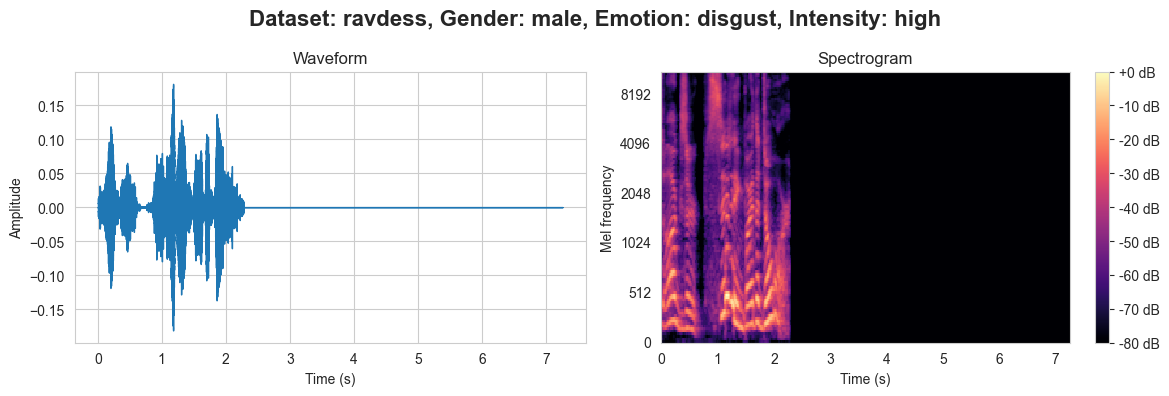

In [20]:
play_random_audio(merged_df, gender="male", emotion="disgust", intensity="high", preprocess=True)

# Baseline model

## 2D Convolution on MFCC images

In [ ]:
data_creator = MFCCDataCreator(num_mfcc=30)

In [ ]:
X_mfcc, X_audio, sr_list, y, max_length = data_creator.create_data(merged_df)

In [ ]:
preprocessor = DataPreprocessor(X_mfcc, y, merged_df)
X_train_scaled, X_val_scaled, X_test_scaled, y_train_categorical, y_val_categorical, y_test_categorical, num_classes, class_labels = preprocessor.preprocess_data()

### 3x3 kernel model

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel3by3.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')

### 4x10 kernel model

Since the MFCC shape is of a wide rectangle, a rectangular kernel might be more fitted for our model Conv2D

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(4, 10), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, kernel_size=(4, 10), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel4by10.h5"),
    create_reduce_lr_callback()
]

history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')

## Data Augmentation

In [ ]:
augmentor = DataAugmentation()

In [ ]:
merged_df.head()

In [ ]:
# Take a random 75% of the data
random_merged_df = merged_df.sample(frac=0.75, random_state=42)
random_merged_df.reset_index(drop=True, inplace=True)
random_merged_df.head()

In [ ]:
# Create a new dataframe to store augmented data
augmented_df = pd.DataFrame(columns=random_merged_df.columns)

In [ ]:
# Set output folder to save augmented audio files
output_folder = './data/augmented_audio'  

In [ ]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
for idx, row in random_merged_df.iterrows():
    audio_path = row['audio_path']
    emotion = row['emotions']
    
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)
    
    # Augment the audio using each method in the DataAugmentation class
    shifted_audio = augmentor.shift_pitch(audio, sr, semitones=2)
    time_shifted_audio = augmentor.time_shift(audio, sr, shift_range=5)
    stretched_audio = augmentor.time_stretch(audio, rate=1.2)
    noisy_audio = augmentor.add_noise(audio, noise_factor=0.1)
    
    # Save the augmented audio if needed
    output_path = os.path.join(output_folder, f'{emotion}_{idx}.wav')
    sf.write(output_path, shifted_audio, sr)
    
    # Append the augmented data to the augmented_df
    augmented_df = pd.concat([augmented_df, 
                              pd.DataFrame([{
                                  'emotions': emotion,
                                  'genders': row['genders'],
                                  'audio_intensity': row['audio_intensity'],
                                  'audio_path': output_path,  # Replace with the actual path if not saving
                                  'duration': row['duration'],
                                  'dataset': row['dataset']
                              }])])

augmented_df.to_csv('augmented_df.csv',index=False)

In [12]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')

In [13]:
final_data = pd.concat([merged_df, augmented_df], axis=0)

In [ ]:
final_data.columns

In [ ]:
final_data.shape

In [ ]:
data_creator = MFCCDataCreator(num_mfcc=40)

In [ ]:
sns.histplot(data=final_data, x='duration', hue='dataset')

In [ ]:
final_data.head()

In [ ]:
X_mfcc, X_audio, sr_list, y, max_length = data_creator.create_data(final_data)

### 3x3 kernel model

In [12]:
preprocessor = DataPreprocessor(X_mfcc, y, final_data)
X_train_scaled, X_val_scaled, X_test_scaled, y_train_categorical, y_val_categorical, y_test_categorical, num_classes, class_labels = preprocessor.preprocess_data()

In [13]:
# Splitting the data into train , val, test datasets
train, val, test = preprocessor.split_dataframe()

In [ ]:
input_shape = X_train_scaled.shape[1:]

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    create_early_stopping_callback(),
    create_model_checkpoint_callback("best_model_kernel3by3_augmentation.h5"),
    create_reduce_lr_callback()
]

In [ ]:
history = model.fit(X_train_scaled, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=50, 
                    validation_data=(X_val_scaled, y_val_categorical),
                    callbacks=callbacks
                    )

In [ ]:
emotion_classifier = EmotionClassifier(model, num_classes, class_labels, test)

In [ ]:
emotion_classifier.predict_sample(X_test_scaled)

In [ ]:
emotion_classifier.evaluate(X_test_scaled, y_test_categorical)

In [ ]:
emotion_classifier.plot_confusion_matrix(X_test_scaled, y_test_categorical, class_labels)

In [ ]:
emotion_classifier.plot_metrics(history)

### 4x10 kernel model

# LSTM features Model

## Base data model

In [63]:
feature_extractor = AudioFeatureExtractor(merged_df)

In [64]:
X, y, df = feature_extractor.create_arrays_data()

In [65]:
df.head()

,emotions,zcr,mfccs
0,neutral,"[[0.1806640625, 0.2666015625, 0.29150390625, 0...","[[-673.8612, -500.93295, -463.58884, -424.6362..."
1,neutral,"[[0.15283203125, 0.16015625, 0.1689453125, 0.0...","[[-518.0421, -479.19376, -434.56332, -396.5498..."
2,neutral,"[[0.16796875, 0.1787109375, 0.19140625, 0.0810...","[[-735.57513, -508.27155, -425.2889, -399.9355..."
3,neutral,"[[0.1611328125, 0.1708984375, 0.18408203125, 0...","[[-638.9588, -446.9245, -372.6338, -361.95847,..."
4,neutral,"[[0.16943359375, 0.255859375, 0.32275390625, 0...","[[-558.5768, -503.0021, -505.46335, -512.21625..."


In [66]:
preprocessor = DataPreprocessor(X, y, df)

In [67]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data()

In [68]:
y_train_encoded, y_val_encoded, y_test_encoded = preprocessor.encode_labels(y_train, y_val, y_test)

In [69]:
y_train_categorical = preprocessor.one_hot_encode_labels(y_train_encoded)
y_val_categorical = preprocessor.one_hot_encode_labels(y_val_encoded)
y_test_categorical = preprocessor.one_hot_encode_labels(y_test_encoded)

In [70]:
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1:3])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 313, 256)          294912    
                                                                 
 dropout_9 (Dropout)         (None, 313, 256)          0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                

In [71]:
callbacks = [
    create_early_stopping_callback(patience=10),
    create_model_checkpoint_callback("best_model_lstm64.h5"),
    create_reduce_lr_callback(patience=10)
]

history = model.fit(X_train, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs= 50, 
                    validation_data=(X_val, y_val_categorical),
                    callbacks=callbacks
                    )

Epoch 1/50
274/274 [==============================] - 209s 752ms/step - loss: 1.6819 - categorical_accuracy: 0.3064 - val_loss: 1.4807 - val_categorical_accuracy: 0.4203 - lr: 0.0100
Epoch 2/50
274/274 [==============================] - 192s 699ms/step - loss: 1.4745 - categorical_accuracy: 0.4082 - val_loss: 1.3919 - val_categorical_accuracy: 0.4738 - lr: 0.0100
Epoch 3/50
274/274 [==============================] - 202s 737ms/step - loss: 1.3866 - categorical_accuracy: 0.4571 - val_loss: 1.3391 - val_categorical_accuracy: 0.4995 - lr: 0.0100
Epoch 4/50
274/274 [==============================] - 211s 768ms/step - loss: 1.3234 - categorical_accuracy: 0.4790 - val_loss: 1.2740 - val_categorical_accuracy: 0.5242 - lr: 0.0100
Epoch 5/50
274/274 [==============================] - 216s 788ms/step - loss: 1.2572 - categorical_accuracy: 0.5059 - val_loss: 1.2261 - val_categorical_accuracy: 0.5488 - lr: 0.0100
Epoch 6/50
274/274 [==============================] - 222s 810ms/step - loss: 1.2381 

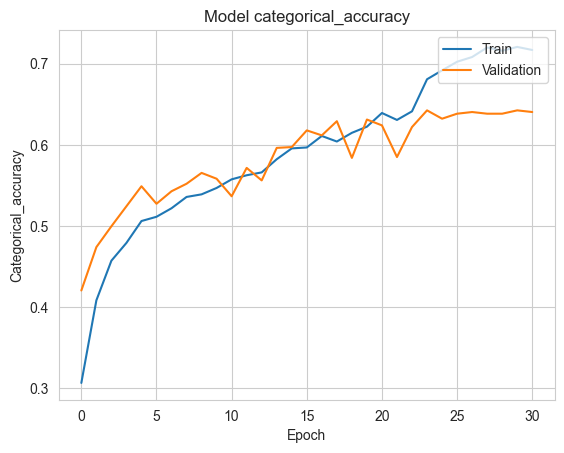

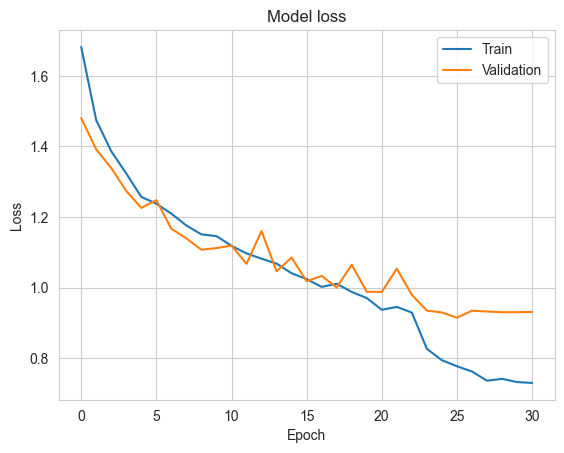

In [72]:
plot_metrics(history, 'categorical_accuracy')
plot_metrics(history, 'loss')

## Base & Augmented data model

In [73]:
merged_df = pd.read_csv('merged_df.csv')
augmented_df = pd.read_csv('augmented_df.csv')

In [74]:
final_data = pd.concat([merged_df, augmented_df], axis=0)

In [75]:
feature_extractor = AudioFeatureExtractor(final_data)

In [76]:
X, y, df = feature_extractor.create_arrays_data()

In [77]:
preprocessor = DataPreprocessor(X, y, df)

In [78]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data()

In [79]:
y_train_encoded, y_val_encoded, y_test_encoded = preprocessor.encode_labels(y_train, y_val, y_test)

In [80]:
y_train_categorical = preprocessor.one_hot_encode_labels(y_train_encoded)
y_val_categorical = preprocessor.one_hot_encode_labels(y_val_encoded)
y_test_categorical = preprocessor.one_hot_encode_labels(y_test_encoded)

In [81]:
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1:3])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 313, 256)          294912    
                                                                 
 dropout_12 (Dropout)        (None, 313, 256)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 7)                

In [82]:
callbacks = [
    create_early_stopping_callback(patience=10),
    create_model_checkpoint_callback("best_model_lstm64_augumentation.h5"),
    create_reduce_lr_callback(patience=10)
]

history = model.fit(X_train, 
                    y_train_categorical, 
                    batch_size=32, 
                    epochs=50, 
                    validation_data=(X_val, y_val_categorical),
                    callbacks=callbacks
                    )

Epoch 1/50
479/479 [==============================] - 378s 784ms/step - loss: 1.6120 - categorical_accuracy: 0.3235 - val_loss: 1.4561 - val_categorical_accuracy: 0.4099 - lr: 0.0100
Epoch 2/50
479/479 [==============================] - 358s 747ms/step - loss: 1.4103 - categorical_accuracy: 0.4244 - val_loss: 1.3307 - val_categorical_accuracy: 0.4416 - lr: 0.0100
Epoch 3/50
479/479 [==============================] - 364s 760ms/step - loss: 1.2977 - categorical_accuracy: 0.4838 - val_loss: 1.2893 - val_categorical_accuracy: 0.4750 - lr: 0.0100
Epoch 4/50
479/479 [==============================] - 367s 766ms/step - loss: 1.2429 - categorical_accuracy: 0.5028 - val_loss: 1.1958 - val_categorical_accuracy: 0.5097 - lr: 0.0100
Epoch 5/50
479/479 [==============================] - 384s 801ms/step - loss: 1.2194 - categorical_accuracy: 0.5085 - val_loss: 1.1978 - val_categorical_accuracy: 0.5203 - lr: 0.0100
Epoch 6/50
479/479 [==============================] - 383s 800ms/step - loss: 1.1903 

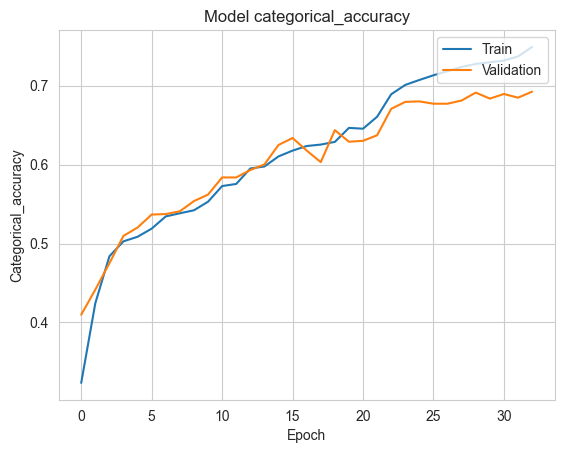

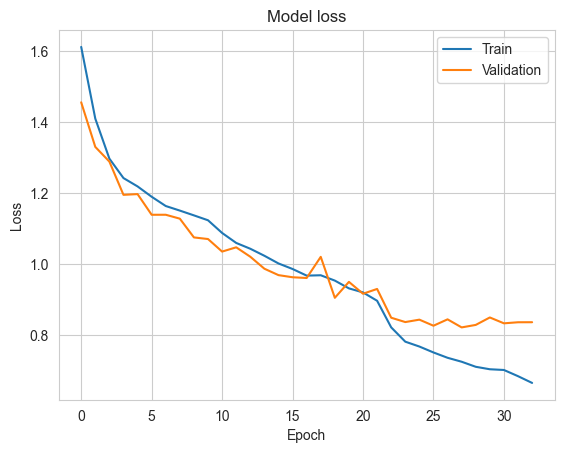

In [83]:
plot_metrics(history, 'categorical_accuracy')
plot_metrics(history, 'loss')

# Transfer learning


## Generating mel spectogram images

In [44]:
width=224
height=224

In [45]:
data_directory = f'spectrogram_images_{width}x{height}'

In [46]:
spectrogram_data_creator = SpectrogramDataCreator(width=width, height=height)
X_spectrogram, y, max_length = spectrogram_data_creator.create_data(final_data, save_folder=data_directory)

In [47]:
train_dir = os.path.join(data_directory, 'train\\')
val_dir = os.path.join(data_directory, 'validation\\')
test_dir = os.path.join(data_directory, 'test\\')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [48]:
# List all image files
image_files = [f for f in os.listdir(data_directory) if f.endswith('.png')]

# Shuffle the image files randomly
random.shuffle(image_files)

# Split ratio (adjust as needed)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [49]:
# Calculate the number of images for each split
num_train = int(train_ratio * len(image_files))
num_val = int(val_ratio * len(image_files))

In [50]:
# Move images to the train directory
for file in image_files[:num_train]:
    src = os.path.join(data_directory, file)
    dst = os.path.join(train_dir, file)
    move(src, dst)

In [51]:
# Move images to the validation directory
for file in image_files[num_train:num_train+num_val]:
    src = os.path.join(data_directory, file)
    dst = os.path.join(val_dir, file)
    move(src, dst)

In [52]:
# Move images to the test directory
for file in image_files[num_train+num_val:]:
    src = os.path.join(data_directory, file)
    dst = os.path.join(test_dir, file)
    move(src, dst)

In [53]:
# List of emotions
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprised"]

In [54]:
# Create subdirectories for each emotion in the train and validation directories
train_dir = os.path.join(data_directory, "train")
val_dir = os.path.join(data_directory, "validation")
test_dir = os.path.join(data_directory, "test")
for emotion in emotions:
    train_emotion_dir = os.path.join(train_dir, emotion)
    val_emotion_dir = os.path.join(val_dir, emotion)
    test_emotion_dir = os.path.join(test_dir, emotion)
    os.makedirs(train_emotion_dir, exist_ok=True)
    os.makedirs(val_emotion_dir, exist_ok=True)
    os.makedirs(test_emotion_dir, exist_ok=True)

In [55]:
def organize_images(directory, emotions):
    for subdir in directory:
        subdir_path = os.path.join(data_directory, subdir)
        for emotion in emotions:
            destination_dir = os.path.join(subdir_path, emotion)
            os.makedirs(destination_dir, exist_ok=True)

        search_pattern = os.path.join(subdir_path, '*.png')
        image_files = glob.glob(search_pattern)

        for image_path in image_files:
            filename = os.path.basename(image_path)
            emotion = filename.split('.')[0].split('_')[-1]
            if emotion in emotions:
                destination_dir = os.path.join(subdir_path, emotion)
                shutil.move(image_path, destination_dir)

In [56]:
organize_images(['train', 'validation', 'test'], emotions)

## MobileNetV2 transfer learning

In [98]:
# MobileNetV2 needs 224x224 images sizes
width = 224
height = 224

In [99]:
data_directory = f'spectrogram_images_{width}x{height}'
train_dir = os.path.join(data_directory, "train")
val_dir = os.path.join(data_directory, "validation")
test_dir = os.path.join(data_directory, "test")

In [100]:
# Image data generator for training data
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=32,
    class_mode='categorical'
)

# Image data generator for validation data
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=32,
    class_mode='categorical'
)

Found 14352 images belonging to 7 classes.
Found 3075 images belonging to 7 classes.


In [101]:
# Image data generator for test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width, height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3077 images belonging to 7 classes.


In [102]:
def build_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.6)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

def compile_model(model, learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
input_shape = (width, height, 3)  # Shape of your spectrogram images
num_classes = 7  # Number of emotion classes

In [104]:
callbacks = [
    create_early_stopping_callback(patience=10),
    create_model_checkpoint_callback("transferLearning_mobilenet_melspec.h5"),
    create_reduce_lr_callback(patience=10)
]

In [105]:
# Build and compile the model
model = build_model(input_shape, num_classes)
compile_model(model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [106]:
# Train the model using the data generator
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    batch_size=32, 
                    callbacks=callbacks, 
                    epochs=50, 
                    shuffle=True)

Epoch 1/50
449/449 [==============================] - 400s 888ms/step - loss: 5.0384 - accuracy: 0.3844 - val_loss: 1.2472 - val_accuracy: 0.5037 - lr: 0.0010
Epoch 2/50
449/449 [==============================] - 394s 878ms/step - loss: 1.3957 - accuracy: 0.4225 - val_loss: 1.2082 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 384s 856ms/step - loss: 1.3893 - accuracy: 0.4262 - val_loss: 1.1503 - val_accuracy: 0.5434 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 384s 855ms/step - loss: 1.3345 - accuracy: 0.4415 - val_loss: 1.1505 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 5/50
449/449 [==============================] - 401s 894ms/step - loss: 1.3269 - accuracy: 0.4395 - val_loss: 1.1536 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 6/50
449/449 [==============================] - 402s 896ms/step - loss: 1.3115 - accuracy: 0.4448 - val_loss: 1.1008 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 7/50
449/449 [==========================

[]

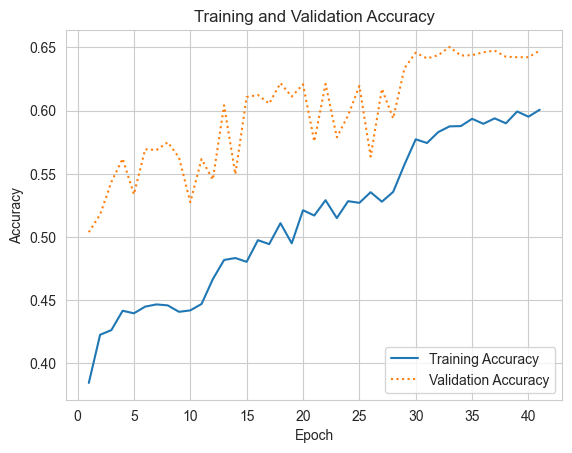

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

97/97 [==============================] - 35s 359ms/step


Text(113.9222222222222, 0.5, 'Actual label')

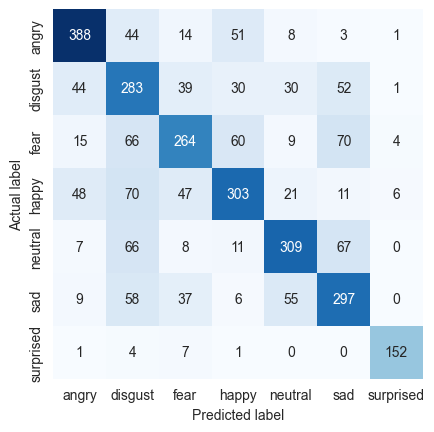

In [108]:
predictions = model.predict(test_generator)
y_predicted = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

mat = confusion_matrix(true_labels, y_predicted)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## VGGISH transfer learning

In [14]:
# VGGISH needs 96x64 images sizes
width = 96
height = 64

In [15]:
data_directory = f'spectrogram_images_{width}x{height}'
train_dir = os.path.join(data_directory, "train")
val_dir = os.path.join(data_directory, "validation")
test_dir = os.path.join(data_directory, "test")

In [16]:
# Image data generator for training data
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=10,
    class_mode='categorical',
    color_mode='grayscale'
)

# Image data generator for validation data
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=10,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 14352 images belonging to 7 classes.
Found 3075 images belonging to 7 classes.


In [17]:
# Image data generator for test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width, height),
    batch_size=10,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 3077 images belonging to 7 classes.


In [18]:
def build_vggish_model(input_shape, weights_path=None):
    input_layer = Input(shape=input_shape)

    # VGGish Convolutional Blocks
    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)

    
    model = Model(inputs=input_layer, outputs=x, name='vggish')

    # Load pre-trained weights (if available)
    if weights_path is not None:
        model.load_weights(weights_path, by_name=True)

    return model

In [19]:
def build_custom_model(input_shape, num_classes, weights_path=None):
    # Build the VGGish model
    vggish_model = build_vggish_model(input_shape, weights_path)

    # Add your dense layers
    x = Flatten()(vggish_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)

    # Add the output dense layer for classification (number of classes)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the custom model with VGGish base and your dense layers
    custom_model = Model(inputs=vggish_model.input, outputs=output_layer)

    return custom_model

In [20]:
# Manually load an image from the train generator
batch_X, batch_y = next(train_generator)
sample_image = batch_X[0]  # Take the first image from the batch

# Check the shape of the sample image
print("Sample Image Shape:", sample_image.shape)

Sample Image Shape: (96, 64, 1)


In [21]:
# Input shape for spectrogram images (96, 64, 1)
input_shape = (width, height, 1) 

num_classes = 7

# Path to the downloaded pre-trained VGGish weights
vggish_weights_path = 'vggish_audioset_weights_without_fc2.h5'

# Build the custom model with VGGish base and dense layers for classification
custom_model = build_custom_model(input_shape, num_classes, weights_path=vggish_weights_path)

In [22]:
chch = build_vggish_model(input_shape, weights_path=None)
chch.summary()

Model: "vggish"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 32, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 16, 128)       0         
                                                                 
 conv3/conv3_1 (Conv2D)      (None, 24, 16, 256)       295168    
                                                                 
 conv3/conv3_2 (Conv2D)      (None, 24, 16, 256)       59008

In [23]:
custom_model.summary()

# Get the weights of the model
weights = custom_model.get_weights()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 32, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 16, 128)       0         
                                                                 
 conv3/conv3_1 (Conv2D)      (None, 24, 16, 256)       295168    
                                                                 
 conv3/conv3_2 (Conv2D)      (None, 24, 16, 256)       590080

In [24]:
callbacks = [
    create_early_stopping_callback(patience=10),
    create_model_checkpoint_callback("transferLearning_vggish_melspec.h5"),
    create_reduce_lr_callback(patience=10)
]

In [ ]:
custom_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = custom_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50
1435/1435 [==============================] - 431s 300ms/step - loss: 1.8633 - accuracy: 0.1959 - val_loss: 1.5682 - val_accuracy: 0.3492 - lr: 0.0010
Epoch 2/50
1435/1435 [==============================] - 460s 321ms/step - loss: 1.4148 - accuracy: 0.4297 - val_loss: 1.2065 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 3/50
1435/1435 [==============================] - 458s 319ms/step - loss: 1.2250 - accuracy: 0.5143 - val_loss: 1.1483 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 4/50
1435/1435 [==============================] - 458s 319ms/step - loss: 1.1537 - accuracy: 0.5469 - val_loss: 1.0979 - val_accuracy: 0.5671 - lr: 0.0010
Epoch 5/50
1435/1435 [==============================] - 458s 319ms/step - loss: 1.0958 - accuracy: 0.5763 - val_loss: 1.0739 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 6/50
1435/1435 [==============================] - 463s 322ms/step - loss: 1.0611 - accuracy: 0.5936 - val_loss: 1.0044 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 7/50
 135/1435 [=>..........

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
predictions = custom_model.predict(test_generator)
y_predicted = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

mat = confusion_matrix(true_labels, y_predicted)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')